In [64]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
DATA_DIR      = "../datasets"
OUT_FILE      = "../datasets/merged/master.csv"
START_DATE    = "2014-09-17"
END_DATE      = "2025-06-09"

Consolidar archivos de criptomonedas

In [66]:
date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')

# DataFrame base con todas las fechas
merged_df = pd.DataFrame(index=date_range)

def load_price_data(folder, prefix, col_name):
    files = sorted(glob(f'{DATA_DIR}/{folder}/{prefix}_*.csv'))
    if not files:
        print(f"⚠️ No se encontraron archivos en ./datasets/{folder}/{prefix}_*.csv")
        return pd.DataFrame()

    dfs = []
    for f in files:
        # Leer las tres primeras filas manualmente
        with open(f, 'r') as file:
            header1 = next(file).strip().split(',')
            header2 = next(file).strip().split(',')
            header3 = next(file).strip().split(',')

        # Combinar headers (ej: "Close BTC-USD")
        combined_header = [f"{h1} {h2}".strip() for h1, h2 in zip(header1, header2)]

        # Ahora leer el resto del archivo
        df = pd.read_csv(f, skiprows=3, names=combined_header)

        # Parsear la columna de fecha
        date_col = combined_header[0]  # normalmente "Price Ticker Date"
        df = df.rename(columns={date_col: "Date"})
        df['Date'] = pd.to_datetime(df['Date'])

        # Tomar solo la columna de interés (ej: "Close BTC-USD")
        price_col = [col for col in df.columns if col.startswith("Close")][0]
        df = df[['Date', price_col]].rename(columns={price_col: col_name})
        dfs.append(df)

    return pd.concat(dfs).drop_duplicates('Date').set_index('Date').sort_index()


def load_yearly_csv(folder, col_name):
    files = sorted(glob(f'{DATA_DIR}/{folder}/*.csv'))
    dfs = []
    for f in files:
        df = pd.read_csv(f, parse_dates=['date'])
        df = df.rename(columns={'date': 'Date', df.columns[1]: col_name})
        dfs.append(df)
    return pd.concat(dfs).drop_duplicates('Date').set_index('Date').sort_index()

def load_fear_index():
    df = pd.read_csv(f'{DATA_DIR}/fear_and_greed_index/fear_and_greed_index.csv', parse_dates=['timestamp'])
    df = df[['timestamp', 'value']].rename(columns={'timestamp': 'Date', 'value': 'fear_greed'})
    return df.drop_duplicates('Date').set_index('Date').sort_index()

def load_trend():
    files = sorted(glob(f'{DATA_DIR}/trend/*/bitcoin_trend_*.csv'))
    dfs = []
    for f in files:
        df = pd.read_csv(f, parse_dates=['date'])
        df = df.rename(columns={'date': 'Date', 'bitcoin': 'trend'})
        dfs.append(df)
    return pd.concat(dfs).drop_duplicates('Date').set_index('Date').sort_index()

# Cargar datasets
merged_df = merged_df.join(load_price_data('btc', 'btc', 'btc_close'))
merged_df = merged_df.join(load_yearly_csv('active_addresses', 'active_addresses'))
merged_df = merged_df.join(load_price_data('dxy', 'dxy', 'dxy_close'))
merged_df = merged_df.join(load_price_data('eth', 'eth', 'eth_close'))
merged_df = merged_df.join(load_fear_index())
merged_df = merged_df.join(load_price_data('gold', 'gold', 'gold_close'))
merged_df = merged_df.join(load_yearly_csv('interest_rate', 'interest_rate'))
merged_df = merged_df.join(load_price_data('sp500', 'sp500', 'sp500_close'))
merged_df = merged_df.join(load_trend())

# Reindexar y rellenar
merged_df = merged_df.sort_index().reindex(date_range)
merged_df = merged_df.interpolate(method='time')  # Interpolación temporal
merged_df = merged_df.ffill().bfill() # Por si hay algún hueco al principio/final

# Guardar CSV
merged_df.to_csv(f'{OUT_FILE}')
print("✔️ Archivo consolidado generado")

merged_df

✔️ Archivo consolidado generado


,btc_close,active_addresses,dxy_close,eth_close,fear_greed,gold_close,interest_rate,sp500_close,trend
2014-09-17,457.334015,143062.0,84.699997,320.884003,30.0,1234.400024,0.09,2001.569946,22.0
2014-09-18,424.440002,143062.0,84.320000,320.884003,30.0,1225.699951,0.09,2011.359985,22.0
2014-09-19,394.795990,143062.0,84.800003,320.884003,30.0,1215.300049,0.09,2010.400024,22.0
2014-09-20,408.903992,148220.5,84.756668,320.884003,30.0,1215.800049,0.09,2005.030029,22.0
2014-09-21,398.821014,153379.0,84.713333,320.884003,30.0,1216.300049,0.09,1999.660034,22.0
...,...,...,...,...,...,...,...,...,...
2025-06-05,101575.953125,562558.0,98.739998,2416.285645,57.0,3350.699951,4.33,5939.299805,37.0
2025-06-06,104390.343750,562558.0,99.190002,2477.194824,45.0,3322.699951,4.33,6000.359863,37.0
2025-06-07,105615.625000,562558.0,99.103002,2526.505371,52.0,3333.399984,4.33,6004.926595,30.0
2025-06-08,105636.156250,562558.0,99.016001,2510.787109,62.0,3344.100016,4.33,6009.493327,30.0


In [67]:
merged_df.index = pd.to_datetime(merged_df.index)
merged_df = merged_df.sort_index()
numeric_cols = merged_df.select_dtypes(include='number').columns.tolist()

# Verificar si hay valores faltantes
faltantes = merged_df[numeric_cols].isnull().sum()
print(f"Valores faltantes por columna: {faltantes[faltantes > 0]}")

Valores faltantes por columna: Series([], dtype: int64)


Calcularemos el retorno logarítmico para BTC. De esta forma suavizaremos las variaciones intentando generar estacionaridad 

El delta elegido para este valor será de 1 día. Es decir calcularemos la diferencia entre cierres de btc entre días.  

r =log(Pt)−log(Pt−n)

También calcularemos RSI con un período de 14 días

In [68]:
# Asegurarse de que la columna btc_close exista
if 'btc_close' not in merged_df.columns:
    raise ValueError("La columna 'btc_close' no está presente en el DataFrame.")

# 1. Retorno logarítmico diario (delta=1)
merged_df['btc_log_return'] = np.log(merged_df['btc_close'] / merged_df['btc_close'].shift(1))

# 2. RSI de 14 días
def calcular_RSI(series, window=14):
    delta = series.diff()
    ganancia = delta.clip(lower=0)
    perdida = -delta.clip(upper=0)

    media_ganancia = ganancia.rolling(window=window).mean()
    media_perdida = perdida.rolling(window=window).mean()

    rs = media_ganancia / media_perdida
    rsi = 100 - (100 / (1 + rs))
    return rsi

merged_df['btc_rsi'] = calcular_RSI(merged_df['btc_close'], window=14)
merged_df.to_csv(f'{OUT_FILE}')
df = merged_df
print("✔️ Archivo con RSI y retorno BTC guardado")

✔️ Archivo con RSI y retorno BTC guardado


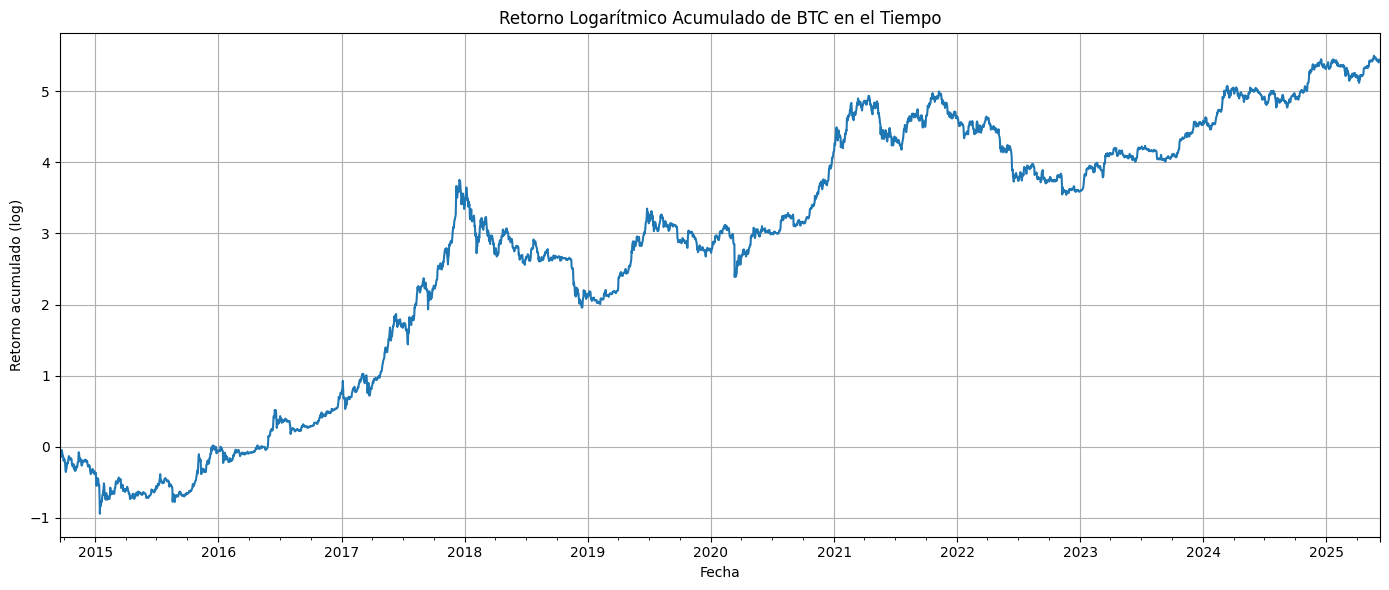

In [69]:
# Calcular el retorno logarítmico acumulado
df['btc_log_cumsum'] = df['btc_log_return'].cumsum()

# Graficar
plt.figure(figsize=(14, 6))
df['btc_log_cumsum'].plot()
plt.title('Retorno Logarítmico Acumulado de BTC en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Retorno acumulado (log)')
plt.grid(True)
plt.tight_layout()
plt.show()
